# Projeto 1 - Ciência dos Dados
## Classificador Naive Bayes

Nome: Pedro Cliquet Amaral

Nome: Luciano Felix Dias

## Etapa 2 - Construção de um modelo de classificação

---
## 1) Preparando o ambiente no Jupyter:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from numpy import random

---
## 2) Carregando a base de dados

In [2]:
filename = 'database.xlsx'

In [3]:
train = pd.read_excel(filename, sheet_name = 'Treinamento')
train.head(5)

,Tweets,Relevancia
0,@aakkari @furia tem um champ no league of lege...,0
1,@raylerchil @noideapraisso @paulokogos_ofc kkk...,0
2,a faculdade ta atrapalhando meu desempenho no ...,1
3,league of legends é pior do que perder q vida ...,1
4,eu te odeio league of legends lixo de jogo lixo,1


In [4]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Tweets,Relevancia
0,uma call do supermercado vendo anime e a outra...,0
1,#pulgapreta #leagueoflegends #nimotv pulgapret...,0
2,"fico de cara que vem uns zé buceta fala ""ah ma...",0
3,@hastadvalorant esquece league of legends e ba...,0
4,saudade de jogar league of legends com elas,1


___
## 3) Modelo de classificação


### 3.1) Cleaner

In [5]:
def normalize (text):
    """
        Função que normaliza os caracteres dos tweets.
    """
    text_lower = text.lower()

    clear_matches = [
        r"[!-.\:\;\"\'/\\]",         # Pontuações
        r"\b\w{,2}\b",               # Palavras curtas
        r"[@#]\S+",                  # Marcações e Hashtags
        r"https?:\/\/\S+|www.\S+",   # Links
    ]
    clear_replacement = ""           # Limpa a correspondência
    clear_patterns = "|".join(clear_matches)
    clear_pattern = re.compile(clear_patterns)

    space_matches = [
        r"\s?([^\s\w])"              # Emojis não espaçados
    ]
    space_replacement = " \g<1>"     # Insere espaço antes da correspondência
    space_patterns = "|".join(space_matches)
    space_pattern = re.compile(space_patterns)

    post_clear_matches = [
        r"^\s+",                     # Espaços consecutivos no inicio do texto
        r"\s+$",                     # Espaços consecutivos no fim do texto
        r"\s+(?=\s)"                 # Espaços consecutivos entre do texto
    ]
    post_clear_replacement = ""      # Limpa a correspondência
    post_clear_patterns = "|".join(post_clear_matches)
    post_clear_pattern = re.compile(post_clear_patterns)

    cleared = re.sub(clear_pattern, clear_replacement, text_lower, 0)
    spaced = re.sub(space_pattern, space_replacement, cleared, 0)
    post_cleared = re.sub(post_clear_pattern, post_clear_replacement, spaced, 0)

    return post_cleared

### 3.2) Dicionário de palavras

In [6]:
def extract_words (series):
    """
        Função que extrai as palavras de uma Series.
    """
    split = [line.split() for line in series]
    words = [word for line in split for word in line]
    
    return pd.Series(words)


### 3.3) Naive Bayes

In [7]:
def P_palavra (palavra, dicio, length):
    """
        Função que calcula a probabilidade de uma palavra dado um dicionário de palavras com suavização de Laplace.
    """
    ocor = dicio[palavra] if palavra in dicio else 0
    prob = (ocor + 1) / (length + len(dicio))

    return prob


### 3.4) Classificador

In [8]:
class classificador:
    def __init__ (self, df, data_column, category_column):
        self.columns = (data_column, category_column)

        data = df[data_column]
        words = extract_words(data)
        self.length = len(words)

        categories = df[category_column].cat.categories

        self.categories = {}
        for category in categories:
            cat_filter = df[category_column] == category
            filtered = df.loc[cat_filter]
            data = filtered[data_column]
            words = extract_words(data)

            self.categories[category] = {
                "table": words.value_counts(),
                "length": len(words)
            }
    
    def probabilidades (self, frase):
        normalized = normalize(frase)
        
        P_list = []
        for category, data in self.categories.items():
            table = data["table"]
            length = data["length"]
            
            P_cat = length / self.length
            P_frase_dado_cat = 1

            for palavra in normalized.split():
                P = P_palavra(palavra, table, length)
                P_frase_dado_cat *= P

            P_cat_dado_frase = P_frase_dado_cat * P_cat
            P_list.append((category, P_cat_dado_frase))

        return pd.DataFrame(P_list, columns=self.columns)

    def classifica (self, frase):
        sorted_prob = self.probabilidades(frase).sort_values(by="Relevancia", ascending=False)

        return sorted_prob.iloc[0, 0]


---
## 4) Treinamento do modelo

### 4.1) Normalização e categorização da base de dados de treinamento

In [9]:
# Normalização dos tweets
train["Tweets"] = train["Tweets"].apply(normalize)

# Criação das categorias de relevância
train.Relevancia = train.Relevancia.astype("category")
train.Relevancia.cat.categories = ["Irrelevante","Relevante"]

train

,Tweets,Relevancia
0,tem champ league legends que chama akali sempr...,Irrelevante
1,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,Irrelevante
2,faculdade atrapalhando meu desempenho league l...,Relevante
3,league legends pior que perder vida sim,Relevante
4,odeio league legends lixo jogo lixo,Relevante
...,...,...
295,não sei continuo jogando esse jogo desgraçado ...,Relevante
296,larguei league legends vou voltar virar gente,Relevante
297,odeio league legends,Relevante
298,esse league legends uma puta pediu pra atualiz...,Relevante


In [10]:
relevante = train["Relevancia"] == "Relevante"
train_R = train.loc[relevante]

train_R.head()

,Tweets,Relevancia
2,faculdade atrapalhando meu desempenho league l...,Relevante
3,league legends pior que perder vida sim,Relevante
4,odeio league legends lixo jogo lixo,Relevante
7,league legends jogo podre nojento,Relevante
8,vezes acho que fato não poder jogar league leg...,Relevante


In [11]:
irrelevante = train["Relevancia"] == "Irrelevante"
train_I = train.loc[irrelevante]

train_I.head()

,Tweets,Relevancia
0,tem champ league legends que chama akali sempr...,Irrelevante
1,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,Irrelevante
5,unico defeito kim heechul ser diamante jogo le...,Irrelevante
6,league legends segredos para chegar mestre com...,Irrelevante
10,vivo jogando league legends,Irrelevante


### 4.2) Aplicação do modelo classificador

In [12]:
classificador_tweets_lol = classificador(train, "Tweets", "Relevancia")

### 4.3) Verificação dos dicionários

In [13]:
{cat: val["length"] for cat, val in classificador_tweets_lol.categories.items()}

{'Irrelevante': 2521, 'Relevante': 1312}

### 4.4) Teste unitário

In [14]:
frase = "lalaaaa bib tsd"

P_frase = classificador_tweets_lol.probabilidades(frase)

P_frase.sort_values(by="Relevancia", ascending=False).head()

,Tweets,Relevancia
1,Relevante,5.070019e-11
0,Irrelevante,1.426275e-11


---
## 5) Teste to modelo

### 5.1) Normalização, categorização e verificação da base de dados de teste

In [15]:
# Normalização dos tweets
test["Tweets"] = test["Tweets"].apply(normalize)

# Criação das categorias de relevância
test.Relevancia = test.Relevancia.astype("category")
test.Relevancia.cat.categories = ["Irrelevante","Relevante"]

# Verificação da base de dados utilizando o modelo de classificção
test["Verifica"] = test["Tweets"].apply(classificador_tweets_lol.classifica)

test["Acerto"] = test["Verifica"] == test["Relevancia"]
test["Acerto"] = test["Acerto"].astype("category")
test["Acerto"].cat.categories = ["Errou", "Acertou"]

test

,Tweets,Relevancia,Verifica,Acerto
0,uma call supermercado vendo anime outra jogand...,Irrelevante,Relevante,Errou
1,pulgapreta leagueoflegends nimotv pulgapreta e...,Irrelevante,Irrelevante,Acertou
2,fico cara que vem uns buceta fala mas tanta im...,Irrelevante,Relevante,Errou
3,esquece league legends baixa algum moba celula...,Irrelevante,Relevante,Errou
4,saudade jogar league legends com elas,Relevante,Relevante,Acertou
...,...,...,...,...
195,depois assalto valença que levaram meu celular...,Relevante,Relevante,Acertou
196,time league legends furb dos lineups furb spor...,Irrelevante,Relevante,Errou
197,mal vejo hora chegar casa pra jogar aquele mal...,Relevante,Relevante,Acertou
198,como bom xingar jogo league legends,Relevante,Relevante,Acertou


___
## 6) Verificando a performance do Classificador

In [16]:
pd.crosstab(test["Relevancia"], test["Acerto"], normalize=True)

Acerto,Errou,Acertou
Relevancia,,
Irrelevante,0.470,0.075
Relevante,0.005,0.450


___
## 8) Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

### 8.1) Fusão da base de dados

In [17]:
assert_train = pd.read_excel(filename, sheet_name = "Treinamento")
assert_test = pd.read_excel(filename, sheet_name = "Teste")
assert_df = pd.concat([assert_train, assert_test], ignore_index=True)

assert_df["Tweets"] = assert_df["Tweets"].apply(normalize)

assert_df["Relevancia"] = assert_df["Relevancia"].astype("category")
assert_df["Relevancia"].cat.categories = (["Irrelevante","Relevante"])

assert_df

,Tweets,Relevancia
0,tem champ league legends que chama akali sempr...,Irrelevante
1,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,Irrelevante
2,faculdade atrapalhando meu desempenho league l...,Relevante
3,league legends pior que perder vida sim,Relevante
4,odeio league legends lixo jogo lixo,Relevante
...,...,...
495,depois assalto valença que levaram meu celular...,Relevante
496,time league legends furb dos lineups furb spor...,Irrelevante
497,mal vejo hora chegar casa pra jogar aquele mal...,Relevante
498,como bom xingar jogo league legends,Relevante


### 8.2) Embaralhamento e divisão da base de dados, Treinamento e teste do modelo de classificação

In [18]:

acerto_R_list = []
acerto_I_list = []
erro_R_list   = []
erro_I_list   = []

for i in range(1000):
    df_permute    = assert_df.reindex(random.permutation(assert_df.index))
    permute_test  = df_permute.iloc[0:200]
    permute_train = df_permute.iloc[200:500]

    classificador_tweets_lol = classificador(permute_train, "Tweets", "Relevancia")
    permute_test["verifica"] = permute_test["Tweets"].apply(classificador_tweets_lol.classifica)

    hits = permute_test["verifica"] == permute_test["Relevancia"]
    cross_table = pd.crosstab(permute_test["verifica"], hits, normalize=True)

    acerto_R = cross_table.loc["Relevante", True]
    acerto_I = cross_table.loc["Irrelevante", True]
    erro_R   = cross_table.loc["Relevante", False]
    erro_I   = cross_table.loc["Irrelevante", False]

    acerto_R_list.append(acerto_R)
    acerto_I_list.append(acerto_I)
    erro_R_list.append(erro_R)
    erro_I_list.append(erro_I)

<ipython-input-18-a827e8841abe>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permute_test["verifica"] = permute_test["Tweets"].apply(classificador_tweets_lol.classifica)


### 8.3) Gráficos conclusivos da qualidade do modelo

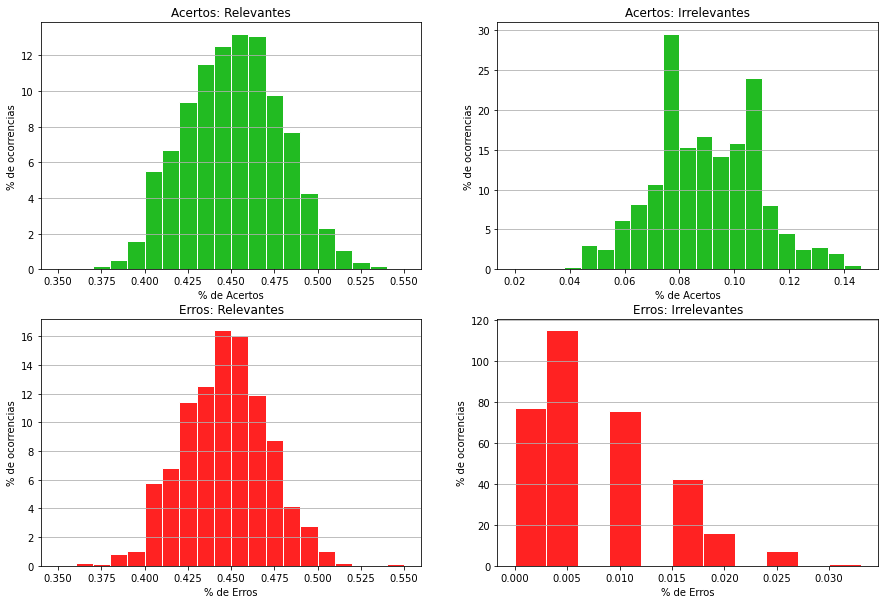

In [28]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
faixa_1 = np.arange(0.35, 0.55, 0.01)
plt.hist(acerto_R_list, bins=faixa_1, density=True, color="#22BB22", edgecolor="w")
plt.title("Acertos: Relevantes")
plt.xlabel("% de Acertos")
plt.ylabel("% de ocorrencias")
plt.grid(axis="y")

plt.subplot(2, 2, 2)
faixa_2 = np.arange(0.02, 0.150, 0.006)
plt.hist(acerto_I_list, bins=faixa_2, density=True, color="#22BB22", edgecolor="w")
plt.title("Acertos: Irrelevantes")
plt.xlabel("% de Acertos")
plt.ylabel("% de ocorrencias")
plt.grid(axis="y")

plt.subplot(2, 2, 3)
faixa_3 = np.arange(0.35, 0.55, 0.01)
plt.hist(erro_R_list, bins=faixa_3, density=True, color="#FF2222", edgecolor="w")
plt.title("Erros: Relevantes")
plt.xlabel("% de Erros")
plt.ylabel("% de ocorrencias")
plt.grid(axis="y")

plt.subplot(2, 2, 4)
faixa_4 = np.arange(0, 0.035, 0.003)
plt.hist(erro_I_list, bins=faixa_4, density=True, color="#FF2222", edgecolor="w")
plt.title("Erros: Irrelevantes")
plt.xlabel("% de Erros")
plt.ylabel("% de ocorrencias")
plt.grid(axis="y")

plt.savefig("plots/qualidade.png", dpi=300)
plt.show()

___
## 10) Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/)

___
## 7) Conclusão

Nesse projeto, utilizamos o método Naive Bayes com suavização de Laplace para categorização automática de relevância de tweets, mas o modelo se mostrou rudimentar para a classificar frases que possam conter significados subjetivos. Pois a classificação dessas frases através da probabilidade de cada palavra independente, elimina qualquer relação intrínseca entre as palavras que compõem o significado diretamente condizente com a classificação esperada da frase. A partir dessas observações, é esperado que o nosso modelo não consiga classificar com acurácia a maior parte dos tweets selecionados. 

Um dos motivos se deu pelo desbalanceamento na seleção dos tweets que construíam os dicionários de palavras que usamos para treinar o nosso classificador. Esse desbalanceamento é uma diferença na quantidade de palavras nos dicionários de ocorrência entre cada categoria, consequentemente, o classificador tornou tendenciosos os resultados obtidos do modelo.

Essa tendência impossibilita usar o próprio classificador para criar novas amostras de treinamento, porque ao adicionar novas amostras é necessário que essa amostra seja classificada manualmente a fim de manter um resultado coerente com o esperado. Dessa forma, uma incoerência no resultado pode gerar uma imprecisão em novos resultados gerados pelo modelo, criando respostas mais imprecisas a cada nova classificação.

Embora este projeto não tenha uma aplicação prática confiável, o método de classificação automática pode ser muito útil em contextos menos complexos. Um  exemplo de aplicação seria, em uma barra para pesquisa de nomes, um modelo que seleciona nomes em uma lista com base em uma pesquisa e a correlação dos caracteres. Um caso teórico nesse exemplo acima seria a pessoa por “Pedra” (um nome não conhecido), a máquina iria sugerir “Pedro” (nome conhecido e semelhante).

A explicação para nosso classificador ser limitado é encontrada na definição do conceito rede neural (neural network) explicada na página do SAS (2021). Isso porque nosso classificador possui apenas uma função (ou neurônio) que ao receber uma entrada (input) determina uma saída (output).

Para melhorar esse classificador, podemos ampliar a rede de neurônios do nosso modelo. Uma rede neural é composta de funções, que chamamos de neurônios.  Um neurônio recebe uma informação e, através de uma lógica própria, gera um resultado. Neste projeto, um único neurônio recebe uma frase e retorna se ela é relevante ou não.

Quando criamos uma rede neural ela irá receber o input, ele será processado pelo primeiro neurônio, e seu resultado passará por outros neurônios, e assim, sucessivamente, até retornar um output. No nosso classificador podemos usar o neurônio que classifica relevância, outro que identifica a classe gramatical de cada palavra na frase, outro que identifica a interação entre essas palavras e por último se essa interação é positiva ou negativa. Portanto, o modelo não irá só dizer apenas a relevância de um tweet, mas ele seria capaz de dizer se é uma crítica ou um elogio.

Contudo, nós poderíamos auxiliar uma empresa desenvolvedora de um produto a identificar se seus usuários estão satisfeitos ou não, os problemas mais frequentes e onde eles recebem mais elogios. Acreditamos que o método de classificação automática de frases facilita encontrar e solucionar problemas; consequentemente, a empresa terá mais facilidade em resolvê-los e, portanto, será mais bem vista!

### 7.1) Referências:

**A practical explanation of a Naive Bayes classifier**. 2017. Disponível em: https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier. Acesso em: 09 abr. 2021.

RASCHKA, Sebastian. **Naive Bayes and Text Classification I**: Introduction and Theory. 04 out. 2014. Disponível em: https://arxiv.org/pdf/1410.5329.pdf. Acesso em: 09 abr. 2021.

**Neural Networks - What are they and why do they matter? | SAS**. 2021. Disponível em: https://www.sas.com/en_us/insights/analytics/neural-networks.html. Acesso em: 09 abr. 2021.